In [40]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
dir_in_Lx = '../out/20.0909 Lx/L200only_reg_rf_boruta_all/'

y_compr_tr = pickle.load(open(os.path.join(dir_in_Lx, 'anlyz', 'y_compr_tr.pkl'), 'rb'))
y_compr_te = pickle.load(open(os.path.join(dir_in_Lx, 'anlyz', 'y_compr_te.pkl'), 'rb'))

## Overall

In [42]:
def getRange(x):
    return max(x)-min(x)

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

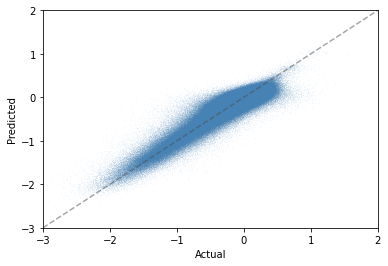

In [43]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(y_compr_te['actual'].values.flatten(), y_compr_te['predicted'].values.flatten(),
                     s = 1, alpha=0.05, linewidth=0, color='steelblue')
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

In [44]:
# get the R2 scores
df_scores = pd.read_csv('%s/anlyz/agg_summary.csv' % dir_in_Lx, index_col=0)

In [45]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']
df_merged = df

### correlation
Compare the CERES score ranges between actual and predicted

In [46]:
dm_data_pkl_file = '../out/20.0817 proc_data/gene_effect/dm_data.pkl'
dm_data = pickle.load(open(dm_data_pkl_file,'rb'))

In [47]:
df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values

In [48]:
range_actual = df_crispr.apply(lambda x: getRange(x), axis=0)

In [49]:
range_pred = df_merged.groupby('gene').apply(lambda x: getCalc(x['predicted']))

[Text(0.5, 0, 'actual CERES range'), Text(0, 0.5, 'predicted CERES range')]

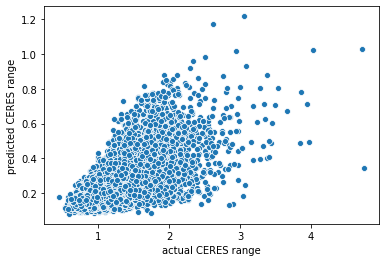

In [50]:
ax = sns.scatterplot(range_actual, range_pred)
ax.set(xlabel='actual CERES range', ylabel='predicted CERES range')

### How many models are predicting just more/less a constant?

In [51]:
pred_range = df_merged.groupby('gene').apply(lambda x: getRange(x['predicted']))
pred_range = pred_range.rename('0')

<AxesSubplot:ylabel='Frequency'>

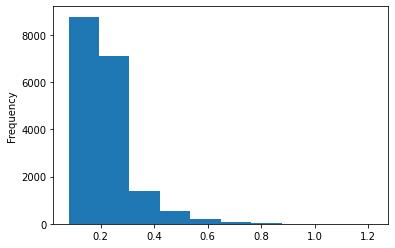

In [52]:
pred_range.plot.hist()

In [53]:
c = (pred_range < 0.45).sum()
pct = c / len(pred_range)
print("total number of models that's predicting more or less constants: %d" % c)
print("%% of models that's predicting more or less constants: %.2f" % pct)

total number of models that's predicting more or less constants: 17443
% of models that's predicting more or less constants: 0.96


In [54]:
c = (pred_range > 0.45).sum()
pct = c / len(pred_range)
print("total number of models that's predicting with differential values: %d" % c)
print("%% of models that's predicting with differential values: %.2f" % pct)

total number of models that's predicting with differential values: 698
% of models that's predicting with differential values: 0.04


### Check specific genes

In [55]:
gene_names = pred_range.index[(pred_range < 0.4) & (pred_range > 0.35)]

In [56]:
gene_names[1]

'ABCB7'

[Text(0.5, 0, 'actual'), Text(0, 0.5, 'predicted'), (-2.5, 1.0), (-2.5, 1.0)]

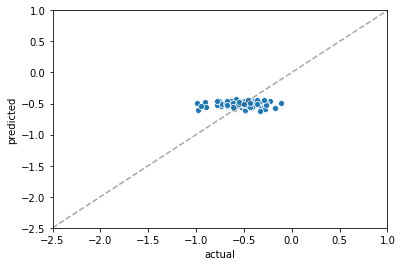

In [57]:
gene_name = 'AAAS'
res = pickle.load(open('%s/model_perf/y_compr_%s.pkl' % (dir_in_Lx, gene_name),'rb'))
df = res['te']
plt.plot([-2.5,1], [-2.5,1], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(df.y_actual, df.y_pred)
ax.set(xlabel='actual', ylabel='predicted', xlim=[-2.5,1], ylim=[-2.5,1])

## Break down by class (based on strict cut-offs of CERES)

In [58]:
# alternatively get dependency class by gene effect cut-offs
dm_data_pkl_file = '../out/20.0817 proc_data/gene_effect/dm_data.pkl'
dm_data = pickle.load(open(dm_data_pkl_file,'rb'))

def classifyDep(x):
    if all(x < -0.5):
        return 'common_essential (<-0.5)'
    elif all((x < 0.5) & (x > -0.5)):
        return 'common_nonessential (near 0s)'
    else:
        return 'selective_essential (others)'

df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
dep_class = df_crispr.apply(lambda x: classifyDep(x), axis=0)
dep_class = dep_class.rename('0')

In [59]:
dep_class.value_counts()

selective_essential (others)     15706
common_nonessential (near 0s)     2090
common_essential (<-0.5)           537
Name: 0, dtype: int64

In [60]:
dep_class.value_counts() / dep_class.shape[0] # percentage

selective_essential (others)     0.856706
common_nonessential (near 0s)    0.114002
common_essential (<-0.5)         0.029291
Name: 0, dtype: float64

In [61]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']

In [62]:
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

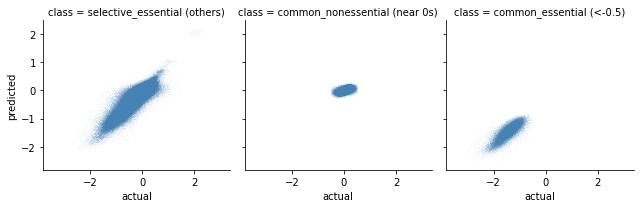

In [63]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

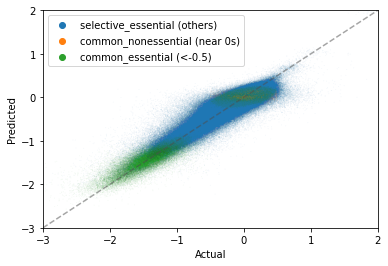

In [64]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(x='actual', y='predicted', data=df_merged, hue=df_merged['class'].tolist(),
                     s = 1, alpha=0.05, linewidth=0)
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

### Correlation
Compare the CERES score ranges between actual and predicted

In [65]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

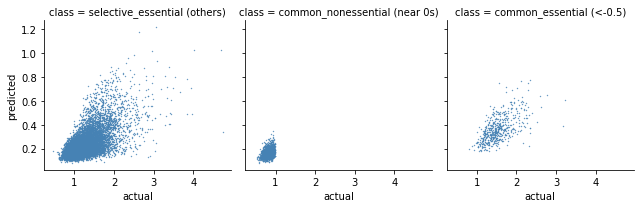

In [66]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [67]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
common_essential (<-0.5)          (0.6071900118998597, 1.3240908028492886e-54)
common_nonessential (near 0s)    (0.33893546823716875, 2.5619900337322196e-57)
selective_essential (others)                         (0.5243599557672152, 0.0)
dtype: object

### Scores

In [68]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


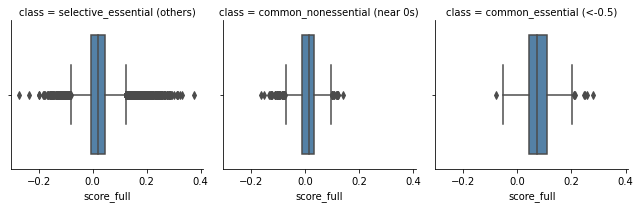

In [69]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [70]:
df.groupby('class').apply(np.mean).T

class,common_essential (<-0.5),common_nonessential (near 0s),selective_essential (others)
score_full,0.077017,0.011069,0.023234
score_rd,0.095714,-0.027451,-0.000137
score_rd10,0.088748,-0.033268,-0.005750
corr_rd10,0.293282,0.106472,0.147712
recall_rd10,0.931062,0.726176,0.774034
p19q4_score_rd10,0.077482,-0.061008,-0.038457
p19q4_corr_rd10,0.270837,0.067265,0.106726
p19q4_recall_rd10,0.888696,0.625972,0.680822


In [71]:
df.groupby('class').aggregate(np.median).T

class,common_essential (<-0.5),common_nonessential (near 0s),selective_essential (others)
score_full,0.07098,0.01344,0.01891
score_rd,0.08803,-0.02499,-0.00678
score_rd10,0.08069,-0.03011,-0.01252
corr_rd10,0.28536,0.10769,0.13972
recall_rd10,0.98800,0.81700,0.87400
p19q4_score_rd10,0.07495,-0.05728,-0.04114
p19q4_corr_rd10,0.28063,0.06463,0.09797
p19q4_recall_rd10,0.97700,0.67400,0.75800


### Predicted range

In [72]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [73]:
df['constant'] = df.pred_range<0.45

In [74]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
common_essential (<-0.5)           424
common_nonessential (near 0s)     2089
selective_essential (others)     14930
Name: constant, dtype: int64

In [75]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
common_essential (<-0.5)         0.801512
common_nonessential (near 0s)    1.000000
selective_essential (others)     0.961799
Name: constant, dtype: float64

Out of 18333 targets, 
- ~2K genes are mostly common non essentials: recall 0.82 | 100% models are constant models
- ~537 genes are mostly common essentials: recall 0.98 | 80% models are constant models
- ~15K genes are others: recall 0.87 | 96% models are constant models

## Break down by SD and range (and looser def of common non/essentials, allowing 1-2 genes outside of range)

In [76]:
# alternatively get dependency class by gene effect cut-offs
def classifyDep(x):
    n = len(x)
    if (np.std(x)>0.25) and ((max(x)-min(x))>0.6) and (sum(x<-0.5)>0):
        return 'selective essential (sd and range)'
    elif (n - sum((x < 0.5) & (x > -0.5))) < 3 :
        return 'mostly common_nonessential (near 0s)'
    if (n - sum(x < -0.5)) < 3:
        return 'mostly common_essential (<-0.5)'
    else:
        return 'Others'

df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
dep_class = df_crispr.apply(lambda x: classifyDep(x), axis=0)
dep_class = dep_class.rename('0')

In [77]:
dep_class.value_counts()

Others                                  10021
mostly common_nonessential (near 0s)     7026
mostly common_essential (<-0.5)           703
selective essential (sd and range)        583
Name: 0, dtype: int64

In [78]:
dep_class.value_counts() / dep_class.shape[0] # percentage

Others                                  0.546610
mostly common_nonessential (near 0s)    0.383243
mostly common_essential (<-0.5)         0.038346
selective essential (sd and range)      0.031801
Name: 0, dtype: float64

In [79]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

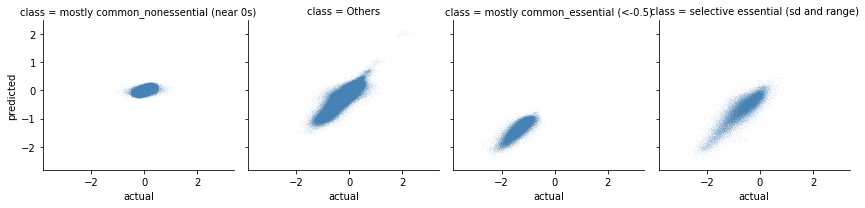

In [80]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

### Correlation
Compare the CERES score ranges between actual and predicted

In [81]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

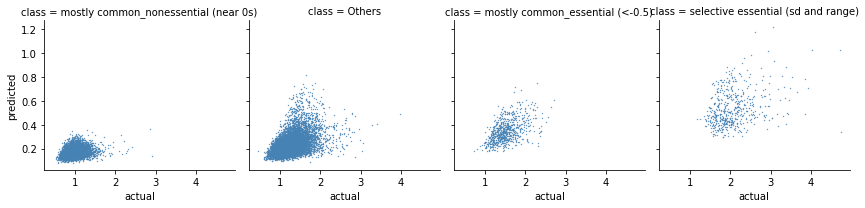

In [82]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [83]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
Others                                                      (0.4611107824670507, 0.0)
mostly common_essential (<-0.5)           (0.5031753161211324, 5.232404669740191e-46)
mostly common_nonessential (near 0s)    (0.2776753034626382, 1.5993045666921057e-124)
selective essential (sd and range)       (0.29290192125257314, 9.124181426800603e-12)
dtype: object

### Scores

In [84]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


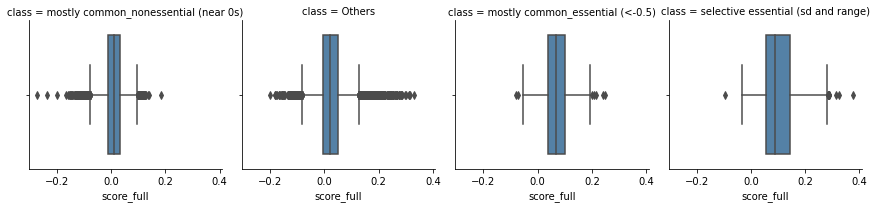

In [85]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [86]:
df.groupby('class').apply(np.mean).T

class,Others,mostly common_essential (<-0.5),mostly common_nonessential (near 0s),selective essential (sd and range)
score_full,0.025700,0.071064,0.009437,0.104197
score_rd,0.004408,0.082413,-0.026999,0.152953
score_rd10,-0.001576,0.073597,-0.032060,0.149050
corr_rd10,0.154685,0.272188,0.108292,0.362505
recall_rd10,0.785660,0.921215,0.727112,0.956261
p19q4_score_rd10,-0.034435,0.062879,-0.063340,0.112267
p19q4_corr_rd10,0.114745,0.255160,0.064961,0.327166
p19q4_recall_rd10,0.693642,0.879383,0.624682,0.919489


In [87]:
df.groupby('class').aggregate(np.median).T

class,Others,mostly common_essential (<-0.5),mostly common_nonessential (near 0s),selective essential (sd and range)
score_full,0.021475,0.06852,0.01092,0.09068
score_rd,-0.002515,0.08031,-0.02440,0.13140
score_rd10,-0.008260,0.07326,-0.03039,0.11969
corr_rd10,0.146870,0.26963,0.10731,0.34953
recall_rd10,0.887000,0.98400,0.81300,0.99800
p19q4_score_rd10,-0.037855,0.06119,-0.05720,0.08924
p19q4_corr_rd10,0.106475,0.25568,0.06507,0.31286
p19q4_recall_rd10,0.777000,0.96500,0.67700,0.98800


### Predicted range

In [88]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [89]:
df['constant'] = df.pred_range<0.45

In [90]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
Others                                  9662
mostly common_essential (<-0.5)          597
mostly common_nonessential (near 0s)    7023
selective essential (sd and range)       161
Name: constant, dtype: int64

In [91]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
Others                                  0.975960
mostly common_essential (<-0.5)         0.856528
mostly common_nonessential (near 0s)    1.000000
selective essential (sd and range)      0.309021
Name: constant, dtype: float64

Out of 18333 targets, 
- ~7K genes are mostly common non essentials: recall 0.81 | 100% of models are constant models
- ~600 genes are mostly common essentials: recall 0.98 | 86% of models are constant models
- ~161 genes are differential essentials: recall 0.99 | 31% of models are constant models
- ~10K genes are others: recall 0.89 | 97% of models are constant models

## Break down by class (based on gene dependency)

In [92]:
# dependency class based on gene dependency (which is a model fit, to get at the probability of being essential)
dep_class = pd.read_csv('../out/20.0817 proc_data_baseline/gene_effect/gene_essential_classification.csv', header=None, index_col=0, squeeze=True)

In [93]:
dep_class.value_counts()

selective_essential    10587
common_nonessential     7322
common_essential         424
Name: 1, dtype: int64

In [94]:
dep_class.value_counts() / dep_class.shape[0] # percentage

selective_essential    0.577483
common_nonessential    0.399389
common_essential       0.023128
Name: 1, dtype: float64

In [95]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']

In [96]:
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

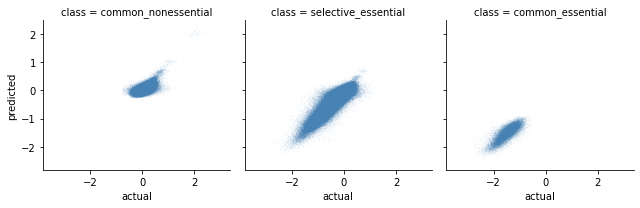

In [97]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

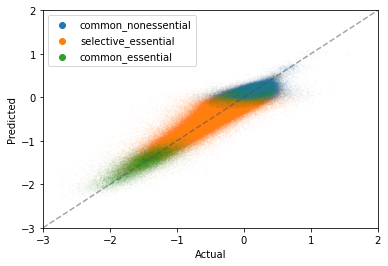

In [98]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(x='actual', y='predicted', data=df_merged, hue=df_merged['class'].tolist(),
                     s = 1, alpha=0.05, linewidth=0)
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

### Correlation
Compare the CERES score ranges between actual and predicted

In [99]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

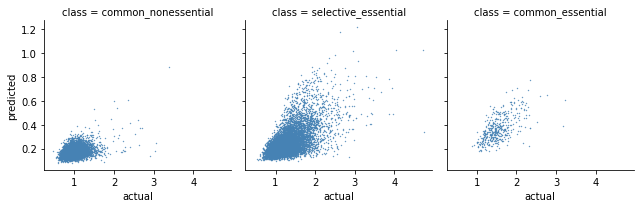

In [100]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [101]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
common_essential        (0.6016096030058545, 2.0946865102402408e-42)
common_nonessential    (0.3163598345934138, 1.0220746044089938e-169)
selective_essential                        (0.5461171198542895, 0.0)
dtype: object

### Scores

In [102]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


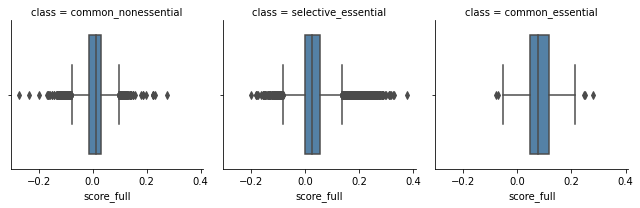

In [103]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [104]:
df.groupby('class').apply(np.mean).T

class,common_essential,common_nonessential,selective_essential
score_full,0.080115,0.009323,0.031023
score_rd,0.100870,-0.026259,0.013564
score_rd10,0.093065,-0.031843,0.007909
corr_rd10,0.297942,0.106228,0.169967
recall_rd10,0.931403,0.722529,0.802301
p19q4_score_rd10,0.082815,-0.063301,-0.024489
p19q4_corr_rd10,0.280159,0.064510,0.129866
p19q4_recall_rd10,0.899424,0.622179,0.712833


In [105]:
df.groupby('class').aggregate(np.median).T

class,common_essential,common_nonessential,selective_essential
score_full,0.07516,0.01065,0.02475
score_rd,0.09424,-0.02423,0.00381
score_rd10,0.08670,-0.03072,-0.00111
corr_rd10,0.29504,0.10507,0.15977
recall_rd10,0.99000,0.80900,0.90600
p19q4_score_rd10,0.07805,-0.05889,-0.03072
p19q4_corr_rd10,0.29180,0.06385,0.11970
p19q4_recall_rd10,0.97900,0.67100,0.80500


### Predicted range

In [106]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [107]:
df['constant'] = df.pred_range<0.45

In [108]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
common_essential        327
common_nonessential    7309
selective_essential    9807
Name: constant, dtype: int64

In [109]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
common_essential       0.784173
common_nonessential    0.999180
selective_essential    0.942165
Name: constant, dtype: float64

Out of 18333 targets, 
- ~7K genes are mostly common non essentials: recall 0.81 | 100% of models are constant models
- ~300 genes are mostly common essentials: recall 0.99 | 78% of models are constant models
- ~10K genes are selective essentials (others): recall 0.91 | 94% of models are constant models

Based on gene dependency: 42% of genes are common non-essential or common essential, but 96% of models are predicting more/less constants

Based on gene effect cut-off: 13% of genes are common non-essential or common essential, but 96% of models are predicting more/less constants

Based on gene dependency: 58% of genes are differential essential, but 4% of models are predicting differential values

Based on gene effect cut-off: 86% of genes are differential essential, but 4% of models are predicting differential values